In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import isnan
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud, STOPWORDS

import fasttext
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve



tqdm.pandas()

%matplotlib inline

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
train = pd.read_csv('../../data/nlp_tweet_data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.shape

(7613, 5)

In [6]:
test = pd.read_csv('../../data/nlp_tweet_data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test.shape

(3263, 4)

In [41]:
class_indexes = list(train['target'].value_counts().index)

## Pre-process

In [8]:
def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    # Clean the text, with the option to remove stopwords and to stem words.

        text = str(text).lower().split()

        # Optionally, remove stop words
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            text = [w for w in text if not w in stops]

        text = " ".join(text)

        # Clean the text
        text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
        text = re.sub(r"\]", " ", text)
        text = re.sub(r"\[", " ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\\", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"  ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"0x00", "", text)
        
        text2 = text.split()
        text = []
        for words in text2:
            if len(words)<2:
                continue
            elif '0x'in words:
                continue
            elif words.isdigit():
                continue
            else:
                text.append(words)
        text = " ".join(text)

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        if lemma:
            text = text.split()
            lem = WordNetLemmatizer()
            lemmatized = [lem.lemmatize(word,"v") for word in text]
            text = " ".join(lemmatized)

        # Return a list of words
        return(text)

In [9]:
def performance_plots(y_test_sample, y_pred, ml_algo):
    print("---------"+ml_algo+"-----------")
    acc = metrics.accuracy_score(y_pred, y_test_sample)
    print("Accuracy: ",acc)
    print("NORMALISED CM  for Tag6")
    cm = confusion_matrix(y_test_sample,y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    ind = class_indexes
    cols = class_indexes
    cm_df = pd.DataFrame(norm_cm,cols,ind)
    plt.figure(figsize=(22,10)) 
    sns.heatmap(cm_df, annot=True,cmap = "Greens",fmt='g')
    print(classification_report(y_test_sample,y_pred))
    print(accuracy_score(y_test_sample, y_pred))
    return

In [10]:
train['text'] = train['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 7613/7613 [00:03<00:00, 2344.79it/s]


In [11]:
test['text'] = test['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 3263/3263 [00:00<00:00, 4502.87it/s]


## Prepare data for fasttext

In [13]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents ask shelter place notify officer eva...,1
3,6,NaN,NaN,people receive wildfires evacuation order cali...,1
4,7,NaN,NaN,get send photo ruby alaska smoke wildfires pou...,1


In [15]:
fasttext_df = train.filter(['target', 'text'], axis=1)
fasttext_df['target']=['__label__'+str(s) for s in fasttext_df['target']]
fasttext_df.head()

,target,text
0,__label__1,deeds reason earthquake may allah forgive us
1,__label__1,forest fire near la ronge sask canada
2,__label__1,residents ask shelter place notify officer eva...
3,__label__1,people receive wildfires evacuation order cali...
4,__label__1,get send photo ruby alaska smoke wildfires pou...


In [16]:
fasttext_df['target'].value_counts()

__label__0    4342
__label__1    3271
Name: target, dtype: int64

In [17]:
## save the data
fasttext_df.to_csv(r'Tweet_fasttext.txt', index=False, sep=' ', header=False)

## Split data to train test set

In [18]:
ind = int(len(fasttext_df)*75/100)
train_fast = fasttext_df[:ind].copy()
train_fast.shape

(5709, 2)

In [19]:
train_fast['target'].value_counts()

__label__0    3296
__label__1    2413
Name: target, dtype: int64

In [20]:
train_fast.to_csv(r'Tweet_train_fasttext.txt', index=False, sep=' ', header=False)

In [21]:
test_fast = fasttext_df[ind:].copy()
test_fast.shape

(1904, 2)

In [22]:
test_fast['target'].value_counts()

__label__0    1046
__label__1     858
Name: target, dtype: int64

In [23]:
test_fast.to_csv(r'Tweet_test_fasttext.txt', index=False, sep=' ', header=False)

In [24]:
test_without_target = test_fast.copy()
test_without_target=test_without_target.drop('target',axis=1)
test_without_target.head()

,text
5709,video we re pick body water rescuers search hu...
5710,video we re pick body water rescuers search hu...
5711,world fear miss migrants med rescuers search s...
5712,durban knight rescuers search hundreds migrant...
5713,unexplainable desire watch rescuers childhoodd...


In [25]:
test_without_target.to_csv(r'Tweet_test_notarget.txt', index=False, sep=' ', header=False)

## Train fasttext

In [29]:
train_path = 'Tweet_train_fasttext.txt'
test_path = 'Tweet_test_fasttext.txt'

hyper_params = {"lr": 0.01,
    "epoch": 100,
    "wordNgrams": 2,
    "minn":2,
    "maxn":4} 

model = fasttext.train_supervised(input=train_path, **hyper_params)

In [30]:
pred_path = 'Tweet_test_notarget.txt'

In [31]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test(test_path))

N	1904
P@1	0.734
R@1	0.734


In [32]:
pred_list = list(test_without_target['text'])

In [33]:
pred = model.predict(pred_list)

In [34]:
pred[0][0][0]

'__label__1'

In [35]:
out = [pred[0][x][0].split('__')[-1] for x in range(len(pred[0]))]
out[:3]

['1', '1', '1']

In [36]:
true = [x.split('__')[-1] for x in test_fast['target']]
true[:3]

['1', '1', '1']

---------fasttext-----------
Accuracy:  0.7226890756302521
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      1046
           1       0.66      0.79      0.72       858

    accuracy                           0.72      1904
   macro avg       0.73      0.73      0.72      1904
weighted avg       0.73      0.72      0.72      1904

0.7226890756302521


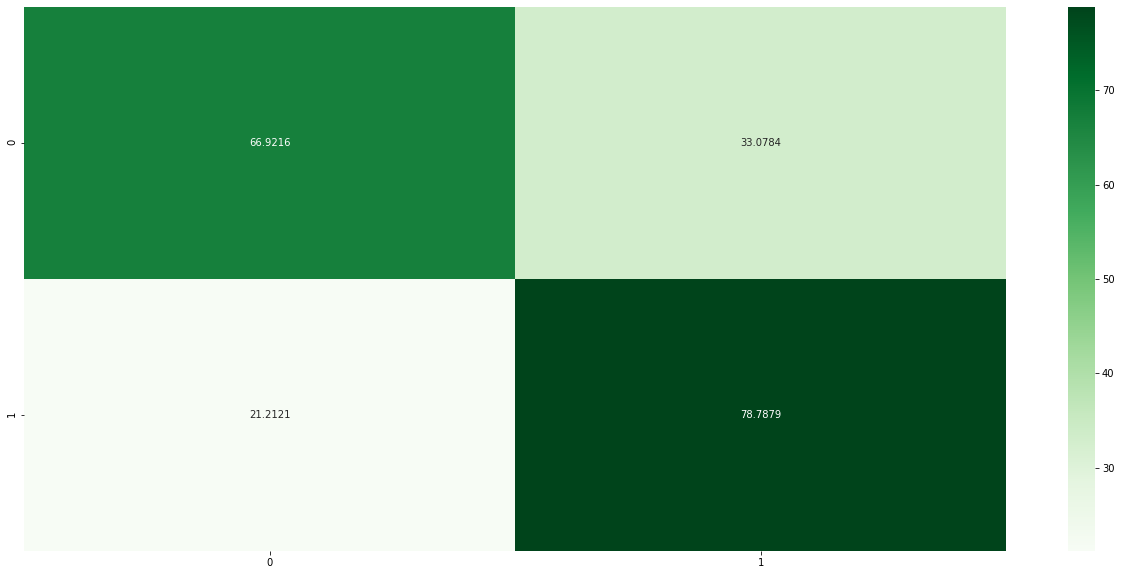

In [42]:
performance_plots(true, out,'fasttext')